---
### Sample Solutions for Temperature Forecast Project
1. **Baseline Model**
2. **FB Prophet**

---

### 1. Making a simple, baseline model
- Only by using monthly means of temperature differences
    - i.e. only by decomposing trend and seasonality.
- Cons:
    - Does not model time dependence.
    - Does not model any remainder (i.e. noise / volatility).
- Pros:
    - Simple reconstruction of trend and seasonality; fairly explainable!

- **DISCLAIMER:** notebook is based off code written by a former spiced student. 
    - Please avoid copying this explicitly (or publishing it online), but merely use it as a reference / borrow some ideas or snippets from it, if you wish.

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

#### a. Read data from Berkeley Earth

In [2]:
##### BERLIN TEMPELHOF
data_raw = pd.read_csv('155194-TAVG-Data.txt', sep='\s+', comment='%', header=None, skiprows=526, skipfooter=10)
data_raw.columns = pd.read_csv('155194-TAVG-Data.txt', nrows=0, skiprows=96, skipinitialspace=True).columns
data_raw.rename(columns={data_raw.columns[0] : data_raw.columns[0].replace('%','').strip()}, inplace=True)

/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


#### b. Clean / Augment Data

In [3]:
data_raw['Date'] = pd.to_datetime(dict(year=data_raw['Year'], month=data_raw['Month'], day=1))
data_raw['Temperature'] = data_raw['Temperature'].fillna(method='bfill')
data_raw = data_raw[['Date', 'Year', 'Month', 'Temperature']]

In [4]:
data_raw.head()

,Date,Year,Month,Temperature
0,1756-01-01,1756,1,5.0
1,1756-02-01,1756,2,5.3
2,1756-03-01,1756,3,7.1
3,1756-04-01,1756,4,10.1
4,1756-05-01,1756,5,14.8


#### c. Split Data

In [5]:
#Use the last 120 data points (=10 years) for testing.
y_train = data_raw.iloc[:-120].reset_index(drop=True) #Jan 1756 - Dec 2002
y_test = data_raw.iloc[-120:].reset_index(drop=True) # Jan 2003 - Dec 2012

In [6]:
y_train.tail()

,Date,Year,Month,Temperature
2959,2002-08-01,2002,8,21.435
2960,2002-09-01,2002,9,15.182
2961,2002-10-01,2002,10,8.455
2962,2002-11-01,2002,11,4.313
2963,2002-12-01,2002,12,-2.023


#### d. Remove the trend (difference the temperature column)

In [7]:
#Apply to training
y_train['Temp_diff'] = y_train['Temperature'].diff().fillna(0.0)


In [8]:
y_train.tail(3)

,Date,Year,Month,Temperature,Temp_diff
2961,2002-10-01,2002,10,8.455,-6.727
2962,2002-11-01,2002,11,4.313,-4.142
2963,2002-12-01,2002,12,-2.023,-6.336


#### e. Extract the Seasonality (from the de-trended data)

In [9]:
y_train['month_means'] = y_train.groupby('Month')['Temp_diff'].transform('mean')

In [10]:
y_train.tail(3)

,Date,Year,Month,Temperature,Temp_diff,month_means
2961,2002-10-01,2002,10,8.455,-6.727,-5.158008
2962,2002-11-01,2002,11,4.313,-4.142,-5.249895
2963,2002-12-01,2002,12,-2.023,-6.336,-3.183008


#### f. Re-construct the time series by taking the cumulative product of the monthly means.
- However, the trick is to make sure that the cumulative sum is based off the original temperature value, so the scale makes sense.

In [11]:
y0_train = y_train.iloc[0]['Temperature']

In [12]:
y0_train

5.0

In [13]:
y_train.loc[0,'month_means'] = y0_train 

#replaces the first point with the real value, so the cumulative sum can be built off of this.
y_train['Prediction'] = np.cumsum(y_train['month_means'])

In [14]:
y_train.head()

,Date,Year,Month,Temperature,Temp_diff,month_means,Prediction
0,1756-01-01,1756,1,5.0,0.0,5.000000,5.000000
1,1756-02-01,1756,2,5.3,0.3,1.501231,6.501231
2,1756-03-01,1756,3,7.1,1.8,2.991227,9.492457
3,1756-04-01,1756,4,10.1,3.0,4.819433,14.311891
4,1756-05-01,1756,5,14.8,4.7,5.140142,19.452032


### g. Apply the same technique to the testing data set!
- The key, however, is that you use the data (month_means) that were learned from the training data!

In [15]:
#Do the same to testing
y_test['month_means'] = y_train.loc[0:120,'month_means']
#use the monthly means from the training data, however!

y_test.loc[0,'month_means'] = y_test.loc[0,'Temperature']
#replaces the first point with the real value, so the cumulative sum can be built off of this.

y_test['Prediction'] = np.cumsum(y_test['month_means'])

Test Score: 0.9206175782329656


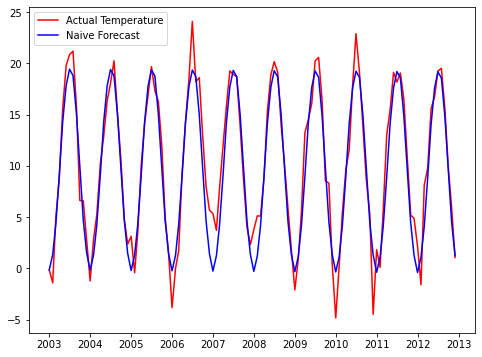

In [16]:
plt.figure(figsize=(8, 6))
plt.plot_date(y_test['Date'],y_test['Temperature'],'r-')
plt.plot_date(y_test['Date'],y_test['Prediction'],'b-')
plt.legend(['Actual Temperature', 'Naive Forecast'])

print(f"Test Score: {r2_score(y_test['Temperature'], y_test['Prediction'])}")

#### h. Extending this model / technique into the future:
- Now that we have a proof of concept that we can replicate the behavior of the trend / seasonality pretty well, let's apply it to the full data set and extend it out into the future.
- Let's predict 30 years into the future
- Create a **"future dataframe"**
    - **KEY**: Make the first day of the *future dataframe* the last day of our *known dataset* (i.e. y_test)

In [17]:
yrs = 30
y_future = pd.DataFrame(index = pd.date_range(start='Dec 2012', periods = 12*yrs, freq='MS'),
             data=[0]*12*yrs,
             columns=['month_means'])

In [18]:
y_future 
#at this point, y_future only contains 1 column (month_means), which is just filled in with zeros

,month_means
2012-12-01,0
2013-01-01,0
2013-02-01,0
2013-03-01,0
2013-04-01,0
...,...
2042-07-01,0
2042-08-01,0
2042-09-01,0
2042-10-01,0


#### i. Make the first value of the future dataset the same as the last value in the known dataset
- Our known dataset (y_test) ends in **December 2012**
- The future dataset (y_future) starts on **December 2012**

In [19]:
#the trick here is that the first value of the future dataset is the temperature of the last day in ytest
y_future.iloc[0, 0] = y_test.iloc[-1]['Temperature']

In [20]:
y_future.head()

,month_means
2012-12-01,1.045
2013-01-01,0.000
2013-02-01,0.000
2013-03-01,0.000
2013-04-01,0.000


#### j. Add in the monthly means that were originally calculated on the training data set!
- This is the trickiest part!
    - Really need to be careful that you're lining up the values for the correct months.
    - Remember, we're using the grouped averages of the monthly temperature DIFFERENCES, so everything is shifted.

In [21]:
mean_training_vals = y_train.groupby('Month')['Temp_diff'].transform('mean')
#the grouped averages of the monthly temp differences, just repeated until the end of the data series

In [22]:
#Insert mean_training_vals starting on the second row onwards. Since the second row happens to be January, it fits right in.
y_future.iloc[1:] = mean_training_vals[0:(12*yrs)-1].values.reshape(-1,1)

In [23]:
y_future.head()

,month_means
2012-12-01,1.045000
2013-01-01,-1.683263
2013-02-01,1.501231
2013-03-01,2.991227
2013-04-01,4.819433


#### k. Again, use the cumulative sum to "extrapolate" / predict into the future!

<AxesSubplot:>

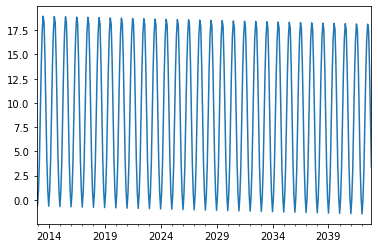

In [24]:
#Use cumulative sum to predict into future
y_future['Prediction'] = np.cumsum(y_future['month_means'])

y_future['Prediction'].plot()

---

Note that the prediction seems to be going down. 
- This naive approach seems to entirely depend on which year you start using for training.
- For example:

In [25]:
data_raw.set_index('Date')['2010':]['Temperature'].diff().mean()

0.16842857142857146

In [36]:
data_raw.set_index('Date')['1790':]['Temperature'].diff().mean()

-0.0002822429906542122

In [26]:
data_raw.set_index('Date')['1980':]['Temperature'].diff().mean()

0.012270886075949373

In [27]:
data_raw.set_index('Date')['1950':]['Temperature'].diff().mean()

0.003329801324503327

In [28]:
data_raw.set_index('Date')['1900':]['Temperature'].diff().mean()

0.00010701107011070604

---

#### Wrapping everything together!

##### Let's try:

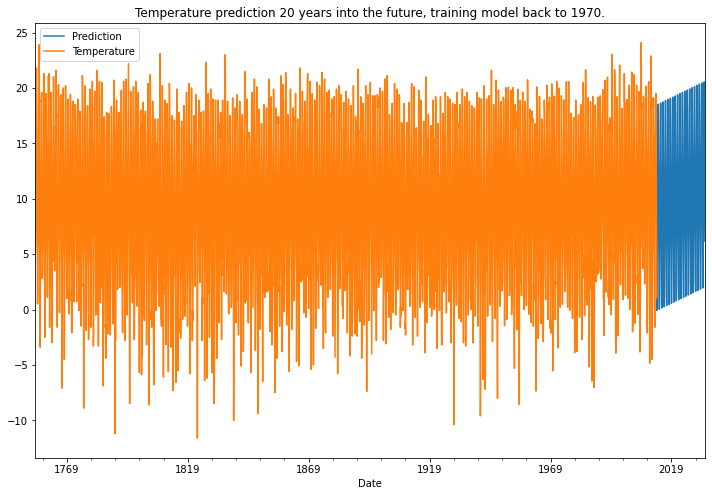

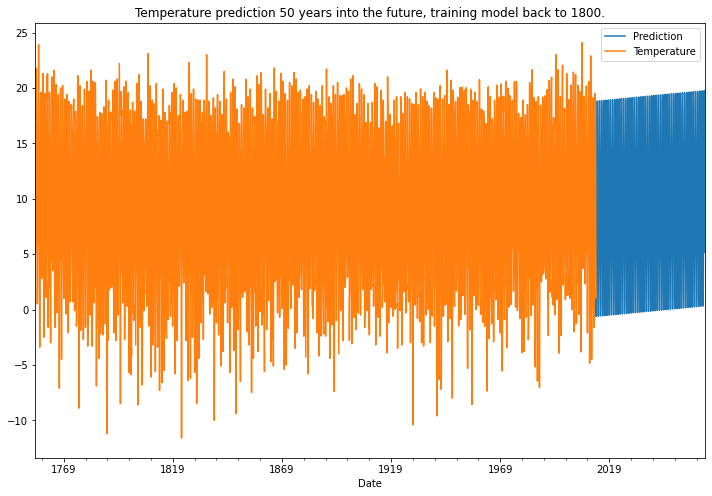

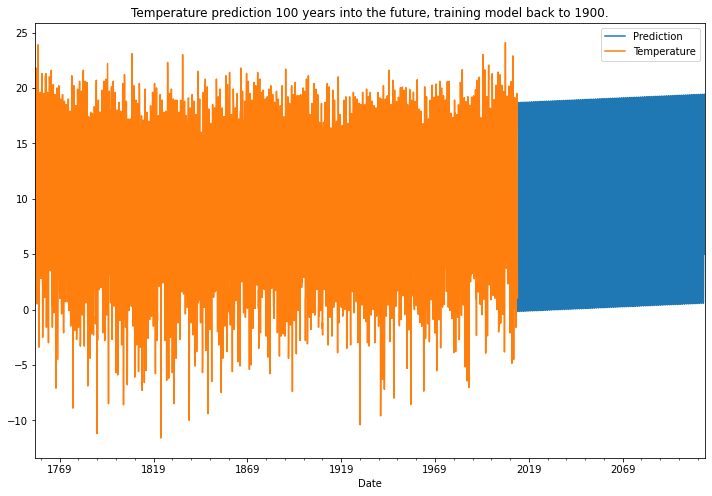

In [29]:
#### Try tweaking these values!! 
#### Depending on how far back in time you take the monthly averages, the trend will change!
yrs = [20, 50, 100]
train_begin = [1970, 1800, 1900]
####

for yr, begin_yr in zip(yrs, train_begin):
    y_future = pd.DataFrame(index = pd.date_range(start='Dec 2012', periods = 12*yr, freq='M'),
                 data=[0]*12*yr,
                 columns=['month_means'])

    #the trick here is that the first value of the future dataset is the temperature of the last day in ytest
    y_future.iloc[0, 0] = y_test.iloc[-1]['Temperature']

    mean_training_vals = y_train.set_index('Date')[f'{begin_yr}':].groupby('Month')['Temp_diff'].transform('mean')
    y_future.iloc[1:] = mean_training_vals[0:(12*yr)-1].values.reshape(-1,1)

    #Use cumulative sum to predict into future
    y_future['Prediction'] = np.cumsum(y_future['month_means'])

    plt.figure(figsize=(12,8))
    y_future['Prediction'].plot(legend=['prediction'])
    data_raw.set_index('Date')['Temperature'].plot(legend=['historical data'])
    plt.title(f'Temperature prediction {yr} years into the future, training model back to {begin_yr}.')


---
---
---

### 2. Using an out-of-the-box, "black-boxy" model 
- FB Prophet (Developed by Facebook)
- Installation: 
    - ``pip install fbprophet``, or
    - ``conda install -c conda-forge fbprophet``, or
    - In case that doesn't work, see installation documentation: https://facebook.github.io/prophet/docs/installation.html#python
        - As of August 2020, there seems to be some strange issues with importing after the conda install:
            - https://github.com/facebook/prophet/issues/1300

![text](https://s.dou.ua/img/announces/prophet-840.png)

---

- Cons:
    - Not easy to understand the math behind it.
    - There **IS** a published paper, which is only 12 pages long ([read it!](https://peerj.com/preprints/3190.pdf)) but it's not super easy to understand.
        - Also see: [The Math of Prophet: Breaking down the Equation behind Facebook’s open-source Time Series Forecasting procedure](https://medium.com/future-vision/the-math-of-prophet-46864fa9c55a)
    - Installation tends to be a bit more tedious / unreliable than it should be.
- Pros:
    - Great Documentation.
    - SUPER EASY to use.
    - Models non-linear trends, fit with yearly, weekly, and daily seasonality, PLUS holiday effects.
        - "*It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.*"

See Youtube Video: [Forecasting at Scale: How and Why We Developed Prophet for Forecasting at Facebook](https://www.youtube.com/watch?v=pOYAXv15r3A)

---

#### a. Prerequisite:
- FB Prophet is a univariate, time series model.
- in order for it to work, you must have a pandas DataFrame with 2 columns:
    - 1st column must be of the Pandas DateTime type and must be called ``ds``
    - 2nd column must be some numerical variable you're trying to forecast, and must be called ``y``

In [37]:
### Let's just do it on the raw, original data (without train-test-split)
df = data_raw[['Date', 'Temperature']]

In [38]:
df = df.rename(columns={'Date':'ds', 'Temperature':'y'})

In [39]:
df.head()

,ds,y
0,1756-01-01,5.0
1,1756-02-01,5.3
2,1756-03-01,7.1
3,1756-04-01,10.1
4,1756-05-01,14.8


#### b. Import model
- *If this step even works for you, congratulations, cause it took me 3 attempts to get the installation working*

In [40]:
from fbprophet import Prophet

In [41]:
m = Prophet(weekly_seasonality=True, daily_seasonality=True)

#### c. Train model

In [42]:
m.fit(df)

*Similar to a generalized additive model (GAM), with time as a regressor, Prophet fits several linear and non-linear functions of time as components. In its simplest form:*

``y(t) = g(t) + s(t) + h(t) + e(t)``

*where:*

- ``g(t)`` -> trend models non-periodic changes (i.e. growth over time)

    - You can also program in "saturated growth", e.g. try setting ``growth='logistic'``
    
- ``s(t)`` -> seasonality presents periodic changes (i.e. weekly, monthly, yearly)

    - *Prophet relies on Fourier series to provide a malleable model of periodic effects.*
    
- ``h(t)`` -> ties in effects of holidays (on potentially irregular schedules ≥ 1 day(s))

- ``e(t)`` -> covers idiosyncratic changes not accommodated by the model


*Prophet is essentially "**framing the forecasting problem as a curve-fitting exercise**" rather than looking explicitly at the time based dependence of each observation.*

#### d. Prepare "future dataframe"

In [43]:
future = m.make_future_dataframe(periods=240, freq='MS', include_history=False)
#20 years into the future

In [44]:
future.tail()

,ds
235,2032-08-01
236,2032-09-01
237,2032-10-01
238,2032-11-01
239,2032-12-01


#### e. Predict

In [45]:
forecast = m.predict(future)

In [46]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,5.972432,-2.441786,2.821569,5.972432,5.972432,-5.707682,-5.707682,-5.707682,4.082383,...,-0.067653,-0.067653,-0.067653,-9.722412,-9.722412,-9.722412,0.0,0.0,0.0,0.264750
1,2013-02-01,5.973778,-1.158441,4.022607,5.973778,5.973778,-4.422502,-4.422502,-4.422502,4.082383,...,0.026483,0.026483,0.026483,-8.531367,-8.531367,-8.531367,0.0,0.0,0.0,1.551277
2,2013-03-01,5.974994,2.000806,7.415313,5.974994,5.974994,-1.148569,-1.148569,-1.148569,4.082383,...,0.026483,0.026483,0.026483,-5.257435,-5.257435,-5.257435,0.0,0.0,0.0,4.826425
3,2013-04-01,5.976340,6.745703,11.987102,5.976340,5.976340,3.472080,3.472080,3.472080,4.082383,...,-0.037409,-0.037409,-0.037409,-0.572893,-0.572893,-0.572893,0.0,0.0,0.0,9.448420
4,2013-05-01,5.977642,12.346740,17.599146,5.977642,5.977642,8.832209,8.832209,8.832209,4.082383,...,0.138541,0.138541,0.138541,4.611285,4.611285,4.611285,0.0,0.0,0.0,14.809851


#### f. Admire

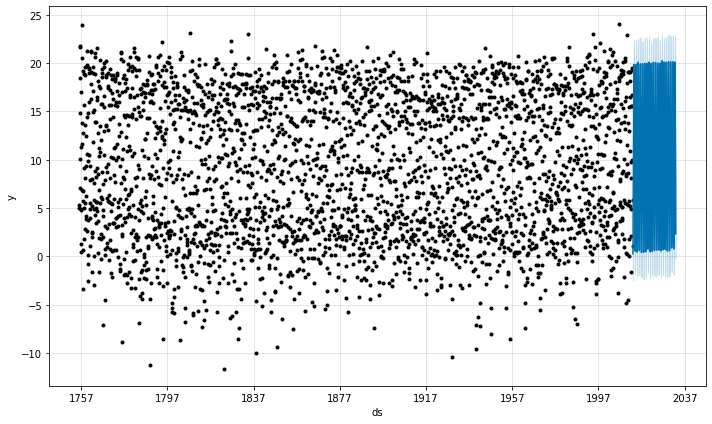

In [47]:
fig = m.plot(forecast)

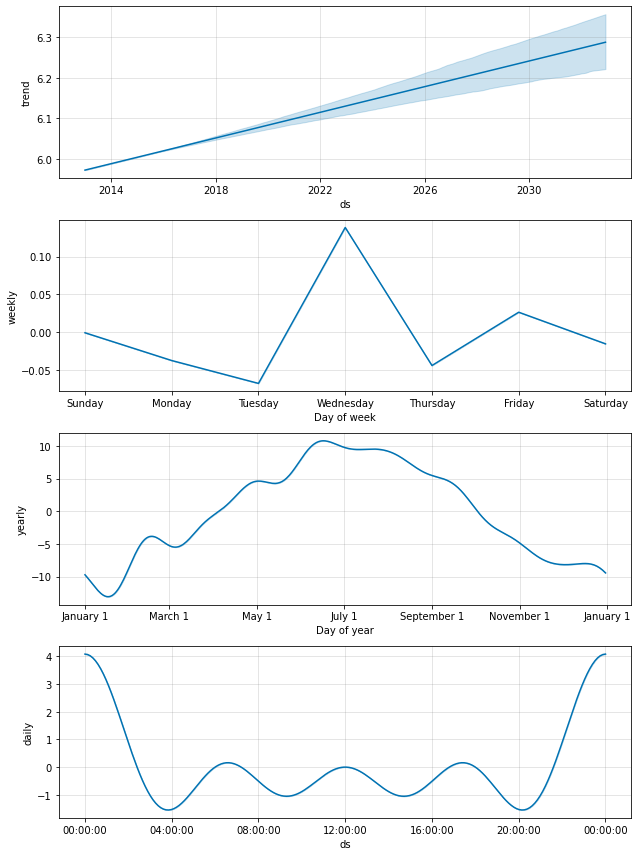

In [48]:
fig2 = m.plot_components(forecast)